# GPS Code Positioning

Εξίσωση Παρατήρησης Κώδικα:
$$ P_{j, rec}^{sat} = \rho _{rec}^{sat} + c \cdot (\delta t_{rec} - \delta t^{sat}) + \delta T_{j, rec}^{sat} + \delta I_{j, rec}^{sat} + \epsilon_{j,rec}^{sat} $$
με

* $j$ = 1,2,5, συχνότητα κύματος,
* $\rho _{rec}^{sat} = \rho(t) _{rec}^{sat} = \sqrt((x^{sat}-x_{rec})^2+(z^{sat}-z_{rec})^2+(z^{sat}-z_{rec})^2)$,
* $\delta t_{rec}$ το σφάλμα χρονομέτρου του δέκτη,
* $\delta t^{sat}$ το σφάλμα χρονομέτρου του δορυφόρου,
* $\delta T_{j, rec}^{sat}$ σφάλμα (καθυστέρηση) λόγω τροπόσφαιρας,
* $\delta I_{j, rec}^{sat}$ σφάλμα (καθυστέρηση) λόγω ιονόσφαιράς,
* $\epsilon$ εναπομείναντα σφάλματα

Για να απαλείψουμε το σφάλμα της ιονόσφαιρας, θα χρησιμοποιήσουμε τον γραμμικό συνδυασμό P3.

Θα χρειαστούμε:
* ένα (data) RINEX v3.x αρχείο, με τις παρατηρήσεις ενός σταθμού

In [1]:
# set the name of the (GNSS) RINEX file to use
rinex_fn = "../../data/DYNG00GRC_R_20240010000_01D_30S_MO.rnx"

* ένα sp3[cd] αρχείο, με τροχιές δουρφόρων GPS που να καλύπτει το διάστημα των παρατηρήσεων του αρχείου RINEX

In [2]:
# set the name of the Sp3 file for the same satellite, covering the same day
sp3_fn = "../../data/COD0MGXFIN_20240010000_01D_05M_ORB.SP3"

* τις παρακάτω βιβλιοθήκες της Python

In [3]:
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.rinex.gnss.rinex import GnssRinex, fetch
from dsoclasses.troposphere import gmf, gpt3
from dsoclasses.time.pyattotime import at2pt, fsec2asec
import attotime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

* συναρτήσεις/μεταβλητές που δημιουργήσαμε στο gps_code_analysis.ipynb

In [4]:
f1 = gs.GPS_L1_FREQ # MHz
f2 = gs.GPS_L2_FREQ # MHz
fac = f1*f1 - f2*f2

# Γεωμετρική απόσταση δορυφόρου-δέκτη
def geometric_range(rsat, rrec): return np.linalg.norm(rsat-rrec)

# Συν/νες δορυφόρου την εποχή εκπομπής
def sat_at_emission_time(rsta, t_reception, interpolator, sat):
    t_emission = t_reception
    x, y, z, clk = interpolator.sat_at(sat, t_emission)
    while True:
        r = geometric_range(np.array((x,y,z)), rsta)
        dt = r / gs.C
        t_emission = t_reception - fsec2asec(dt)
        xnew, ynew, znew, clk = interpolator.sat_at(sat, t_emission)
        if abs(xnew-x)<.1 and abs(ynew-y)<.1 and abs(znew-z)<.1:
            return xnew, ynew, znew, clk, dt
        else:
            x=xnew; y=ynew; z=znew;

# Καρτεσιανές σε αζιμούθιο, γωνία ύψους και απόσταση
def azele(R, rsat, rsta):
    enu = R @ (rsat - rsta)
    r  = np.linalg.norm(enu)
    az = np.arctan2(enu[0], enu[1])
    el = np.arcsin(enu[2] / r)
    return r, az, el

# Υπολογισμός ZHD και προσεγγιστικού ZWD με χρήση μετεωρολογικών δεδομένων GPT3
def static_tropo_delay(t, lat, lon, hgt):
    meteo = gpt3.gpt3(t, lon, lat, hgt, "../../data/gpt3_5.grd")
    zhd = gpt3.saastamoinen_zhd(lat, hgt, meteo['p'])
    zwd = gpt3.askne_zwd(meteo['e'], meteo['Tm'], meteo['la'])
    return zhd, zwd

# Υπολογισμός καθυστέρησης λόγω τροπόσφαιρας με χρήση του Global Mapping Function (gmf)
def tropo_delay(t, lat, lon, hgt, el, zhd, zwd):
    gmfh, gmfw = gmf.gmf(t, lat, lon, hgt, np.pi/2-el)
    return zhd * gmfh + zwd * gmfw

In [5]:
# Παρεμβολή για τις τροχιές
intrp = interpolator.Sp3Interpolator(sp3_fn, ['G'], 3600, 10, 'CubicSpline', True, ['M', 'E'])
# Αρχικοποίηση του αντικειμένου GnssRinex
rnx = GnssRinex(rinex_fn)
# προσεγγιστικές συν/νες δέκτη (από RINEX)
rsta = np.array(rnx.approx_cartesian())
# Μετατροπή σε ελλειψοειδείς συν/νες (δέκτης)
lat, lon, hgt = transformations.car2ell(rsta[0], rsta[1], rsta[2])
# Πίνακας στροφής (x, y, z) -> (e, n, u)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

Skipping sp3 record for satellite G01: missing clock value ([nan])
Skipping sp3 record for satellite G02: missing clock value ([nan])
Skipping sp3 record for satellite G03: missing clock value ([nan])
Skipping sp3 record for satellite G04: missing clock value ([nan])
Skipping sp3 record for satellite G05: missing clock value ([nan])
Skipping sp3 record for satellite G06: missing clock value ([nan])
Skipping sp3 record for satellite G07: missing clock value ([nan])
Skipping sp3 record for satellite G08: missing clock value ([nan])
Skipping sp3 record for satellite G09: missing clock value ([nan])
Skipping sp3 record for satellite G10: missing clock value ([nan])
Skipping sp3 record for satellite G11: missing clock value ([nan])
Skipping sp3 record for satellite G12: missing clock value ([nan])
Skipping sp3 record for satellite G13: missing clock value ([nan])
Skipping sp3 record for satellite G14: missing clock value ([nan])
Skipping sp3 record for satellite G15: missing clock value ([n

Residual too high! Satellite G27 at 18:43:30
Residual too high! Satellite G27 at 18:44:00
Residual too high! Satellite G27 at 18:44:30
Residual too high! Satellite G27 at 18:45:00
Residual too high! Satellite G27 at 18:45:30
Residual too high! Satellite G27 at 18:46:00
Residual too high! Satellite G27 at 18:46:30
Residual too high! Satellite G27 at 18:47:00
Residual too high! Satellite G27 at 18:47:30
Residual too high! Satellite G27 at 18:48:00
Residual too high! Satellite G27 at 18:48:30
Residual too high! Satellite G27 at 18:49:00
Residual too high! Satellite G27 at 18:49:30
Residual too high! Satellite G27 at 18:50:00
Residual too high! Satellite G27 at 18:50:30
Residual too high! Satellite G27 at 18:51:00
Residual too high! Satellite G27 at 18:51:30
Residual too high! Satellite G27 at 18:52:00
Residual too high! Satellite G27 at 18:52:30
Residual too high! Satellite G27 at 18:53:00
Residual too high! Satellite G27 at 18:53:30
Residual too high! Satellite G27 at 18:54:00
Residual t

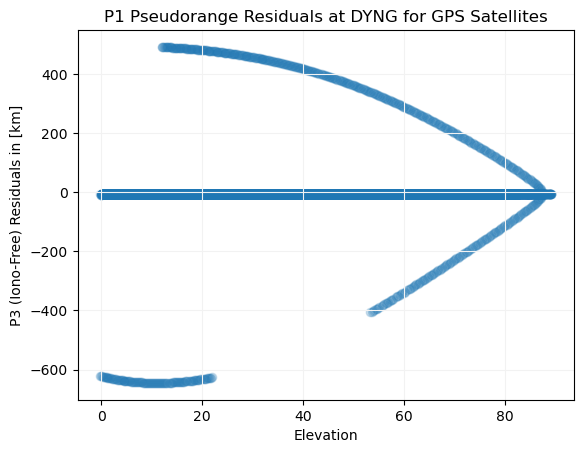

In [6]:
# κενές λίστες για τον χρόνο και την P3
els = []; p3s = [];

# ZHD και ZWD
zhd, zwd = static_tropo_delay(rnx.time_first_obs, lat, lon, hgt)

for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        try:
            p1 = fetch(obs, 'C1W', 'C1C', 'C1X')['value']
            p2 = fetch(obs, 'C2W', 'C2C', 'C2D', 'C2P', 'C2X', 'C2S', 'C2L')['value']
            xsat, ysat, zsat, csat, _ = sat_at_emission_time(rsta, t, intrp, sat)
            r = geometric_range(np.array((xsat,ysat,zsat)), rsta)
            dtsat = gs.C * csat
            pc = f1*f1*p1/fac - f2*f2*p2/fac
            _, _, el = azele(R, np.array((xsat, ysat, zsat)), rsta)
            dT = tropo_delay(rnx.time_first_obs, lat, lon, hgt, el, zhd, zwd)
            p3s.append((pc+dtsat-r-dT)*1e-3); els.append(np.degrees(el));
            if p3s[-1] > 10.:
                print("Residual too high! Satellite {:} at {:}".format(sat, t.strftime("%H:%M:%S")))
        except:
            pass

# Γραφική αναπαράσταση (γωνία ύψους - υπόλοιπα P3)
fig, ax = plt.subplots()
ax.scatter(els, p3s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P3 (Iono-Free) Residuals in [km]")
plt.title("P1 Pseudorange Residuals at {:} for GPS Satellites".format(rnx.marker_name))
plt.xlabel("Elevation")
plt.show()

## Εκτίμηση Συν/νων και Σφάλματος Χρονομέτρου Δέκτη

Οι άγνωστες παράμετροι που θα πρέπει να εκτιμήσουμε είναι:
* $(x, y, z)$ του δέκτη, και
* $\delta t_{rec}$ για κάθε εποχή παρατήρησης

Αντί του $\delta t_{rec}$ για κάθε εποχή παρατήρησης, μπορούμε να χρησιμοποιήσουμε την ποσότητα $c \cdot \delta t_{rec}$.

Η εξίσωση παρατήρησης, για κάθε δορυφόρο ($j$) και κάθε εποχή ($t_i$) είναι:
$$ f_i \equiv PC_{rec}^{j}(t_i) + c \cdot \delta t^{j}(t_i) - \rho _{rec}^{j}(t_i) - c \cdot \delta t_{rec}(t_i) - \delta T_{rec}^{j}(el) = \epsilon_{rec}^{sat}(t_i) $$
με
$\rho _{rec}^{j} = \rho(t) _{rec}^{j} = \sqrt((x^{j}-x_{rec})^2+(z^{j}-z_{rec})^2+(z^{j}-z_{rec})^2)$

Η εξίσωση παρατήρησης είναι μη-γραμμική, συνεπώς θα εκτιμήσουμε τις άγνωστες παραμέτρους (με χρήση της Μεθόδου των Ελαχίστων Τετραγώνων) με επαναλληπτική διαδικασία. Για όλες τις άγνωστες παραμέτρους, χρειαζόμαστε αρχικές τιμές. Για τις (κατεσιανές) συν/νες του δέκτη, θα χρησιμοποιήσουμε τις συν/νες που δίνονται στο RINEX. Για το σφάλμα του ρολογιού, θα ξεκινήσουμε με την τιμή $0$. Άρα:

$\bf{x}_0 = \begin{bmatrix} x_0 & y_0 & z_0 & 0 & 0 & \dots & 0 \end{bmatrix}$

Θα χρειστούμε επίσης τις μερικές παραγώγους ως προς τις άγνωστες παραμέτρους. Θα πρέπει λοιπόν να υπολογίσουμε τον (Ιακωβιανό) πίνακα:
$$ J = \begin{bmatrix} 
\frac{\partial f_1}{\partial x} & \frac{\partial f_1}{\partial y} & \frac{\partial f_1}{\partial z} & 
   \frac{\partial f_1}{\partial (c \delta t_{rec,1})} & \frac{\partial f_1}{\partial (c \delta t_{rec,2})} & \dots &  \frac{\partial f_1}{\partial (c \delta t_{rec,n})}\\
   \frac{\partial f_2}{\partial x} & \frac{\partial f_2}{\partial y} & \frac{\partial f_2}{\partial z} & 
   \frac{\partial f_2}{\partial (c \delta t_{rec,1})} & \frac{\partial f_2}{\partial (c \delta t_{rec,2})} & \dots &  \frac{\partial f_2}{\partial (c \delta t_{rec,n})}\\
   \vdots & \vdots & \vdots & \vdots & \vdots & \dots & \vdots \\
   \frac{\partial f_m}{\partial x} & \frac{\partial f_m}{\partial y} & \frac{\partial f_m}{\partial z} & 
   \frac{\partial f_m}{\partial (c \delta t_{rec,1})} & \frac{\partial f_m}{\partial (c \delta t_{rec,2})} & \dots &  \frac{\partial f_m}{\partial (c \delta t_{rec,n})}\\
\end{bmatrix} $$
Ο Ιακωβιανός, θα υπολογιστεί στις αρχικές τιμές $\bf{x}_0$.

Ο αριθμός των παρατηρήσεων είναι $m$, όσες και οι σειρές του πίνακα $J$. Ο αριθμός των στηλών του $J$ είναι $3 + n$, όπου $n$ οαριθμός των εποχών μετρήσεων. Προφανώς, θα πρέπει να ισχύει $m > n+3$ για να εφαρμόσουμε τα ελάχιστα τετράγωνα.

Τέλος, θα πρέπει να υπολογίσουμε το διάνυσμα των παρατηρούμενων - υπολογισμένων τιμών $\delta l$.

### Βασικές παράμετροι / Επιλογές Ανάλυσης

In [17]:
# Δεν θα χρησιμοποιήσοουμε τον δορυφόρο 27, λόγω πολύ μεγάλων υπολοίπων
EXCLUDE_SATELLITES = ['G27']

# Γωνία αποκοπής· θα χρησιμοποιήσουμε μόνο παρατηρήσεις σε γωνία ύψους μεγαλύτερη από αυτή
ELEVATION_CUT_OFF  = np.radians(3)

# Για ευκολία, μπορούμε να χρησιμοποιήσουμε μόνο παρατηρήσεις που απέχουν μεταξύ τους κάποια δευτερόλεπτα. Έτσι, 
# θα έχουμε μικρότερο αριθμό παρατηρήσεων προς επεξεργασία
EVERY_SEC          = 360.

### Προ-επεξεργασία και συλλογή δεδομένων

Θα συλλέξουμε από το αρχείο RINEX όλες τις παρατηρήσεις που πληρούν τα κριτήρια που θέσαμε. Θα τις αποθηκεύσουμε, μαζί με βασικές πληροφοίες που θα υπολογίσουμε, ώστε έπειτα να κάνουμε την εκτίμηση των παραμέτρων.

In [18]:
# αριθμός εποχών που θα επεξεργαστούμε
num_epochs = 0
# θα αποθηκεύσουμε τις παρατηρήσεις και τα υπολογισμένα στοιχεία εδώ
raw_obs    = []
# εποχή προηγούμενης παρατήρησης
t_prev     = attotime.attodatetime(1900,1,1)

for block in rnx:
    t = block.t()
    # θα χρησιμοποιηθεί η εποχή στην επεξεργασία ?
    epoch_used = False
    # απέχει το bloock τουλάχιστον EVERY_SEC δευτερόλεπτα από το προηγούμενο ?
    if (t-t_prev).total_seconds() >= EVERY_SEC:
        for sat, obs in block.filter_satellite_system("gps", False):
            # περιέχεται ο δορυφόρους στους αποκλεισμένους ?
            if sat not in EXCLUDE_SATELLITES:
                try:
                    p1 = fetch(obs, 'C1W', 'C1C', 'C1X')['value']
                    p2 = fetch(obs, 'C2W', 'C2C', 'C2D', 'C2P', 'C2X', 'C2S', 'C2L')['value']
                    xsat, ysat, zsat, csat, _ = sat_at_emission_time(rsta, t, intrp, sat)
                    r = geometric_range(np.array((xsat,ysat,zsat)), rsta)
                    pc = f1*f1*p1/fac - f2*f2*p2/fac
                    _, _, el = azele(R, np.array((xsat, ysat, zsat)), rsta)
                    # γωνία ύψους >= γωνία αποκοπής ?
                    if el >= ELEVATION_CUT_OFF:
                        dT = tropo_delay(rnx.time_first_obs, lat, lon, hgt, el, zhd, zwd)
                        # αποθηκεύουμε την παρατήρηση
                        raw_obs.append({'t': t, 'p3': pc, 'rsat': np.array((xsat,ysat,zsat)), 'csat': csat, 'el': el, 'dT': dT, 'nepoch': num_epochs})
                        # η εποχή θα χρησιμοποιηθεί
                        epoch_used = True
                except:
                    pass
        if epoch_used:
            # προηγούμενη εποχή παρατήρησης
            t_prev = t
            # αριθμός (μοναδικών) εποχών
            num_epochs += 1

In [19]:
# Αριθμός παρατηρήσεων
m = len(raw_obs)
print("Number of obsevrations: {:}".format(m))

Number of obsevrations: 2309


In [20]:
# Αριθμός αγνώστων παραμέτρων
n = 3 + num_epochs
print("Number of unknown parameters: {:}".format(n))

Number of unknown parameters: 233


### Εφαρμογή Ελαχίστων Τετραγώνων

- Διάνυσμα αρχικών τιμών, $\bf{x}_0$

In [21]:
x0 = np.concatenate((np.array(rsta), np.zeros(num_epochs)))

- Ιακωβιανός: για να τον υπολογίσουμε, χρειαζόμαστε τις μερικές παραγώγους και αρχικές τιμές. $\frac{\partial f_k}{\partial x} = \frac{-(x^{j}-x)}{\sqrt((x^{j}-x)^2+(y^{j}-y)^2+(z^{j}-z)^2)}$ και ομοίως για τα $y$ και $z$. Άρα, $\begin{bmatrix}\frac{\partial f_k}{\partial x} & \frac{\partial f_k}{\partial y} & \frac{\partial f_k}{\partial z} \end{bmatrix} = \frac{1}{\sqrt((x^{j}-x)^2+(y^{j}-y)^2+(z^{j}-z)^2)}\begin{bmatrix}-(x^{j}-x) & -(y^{j}-y) & -(z^{j}-z) \end{bmatrix}$. Τα $\begin{bmatrix}x^{j}&y^{j}&z^{j}\end{bmatrix}$ είναι οι συντεταγμένες του δορυφόρου και $\begin{bmatrix}x&y&z\end{bmatrix}$ οι προσεγγιστικές τιμές.

In [22]:
def gradient(rsat, rrec): 
    r = np.linalg.norm(rsat-rrec)
    return (rrec-rsat) / r

- το διάνυσμα $\delta l$, παρατηρούμενες - υπολογισμένες τιμες, θα το υπολογίσμουμε με βάση τις τιμές που έχουμε αποθηκεύσει.

In [24]:
J   = np.zeros((m, n))
dl  = np.zeros(m)

# for plotting
ephs = [0] * m
elvs = [0] * m

# αριθμός επαναλλήψεων
LS_ITERATIONS = 3
for ls_iteration in range(LS_ITERATIONS):
    # για κάθε παρατήρηση (που έχουμε αποθηκεύσει)
    for i, obs in enumerate(raw_obs):
        # παρατήρηση - υπολογισμένη τιμή
        dl[i] = obs['p3'] + gs.C * obs['csat'] - geometric_range(obs['rsat'], x0[0:3]) - obs['dT'] - x0[3+obs['nepoch']]
        # σειρά Ιακωβιανού
        J[i, 0:3] = gradient(obs['rsat'], x0[0:3]); J[i,3+obs['nepoch']] = 1.;
        # αποθήκευση για γραφική αναπαράσταση
        ephs[i] = at2pt(obs['t']); elvs[i] = np.degrees(obs['el']);
    # διόρθωση δx
    dx = np.linalg.inv(J.transpose() @ J) @ J.transpose() @ dl
    # (νέα) εκτίμηση
    x0 += dx
    print("Iteration {:1d} correction vector: ({:+10.4f}, {:+10.4f},{:+10.4f})".format(ls_iteration, dx[0], dx[1], dx[2]))

Iteration 0 correction vector: (   -0.0000,    -0.0000,   +0.0000)
Iteration 1 correction vector: (   +0.0000,    -0.0000,   -0.0000)
Iteration 2 correction vector: (   +0.0000,    -0.0000,   -0.0000)


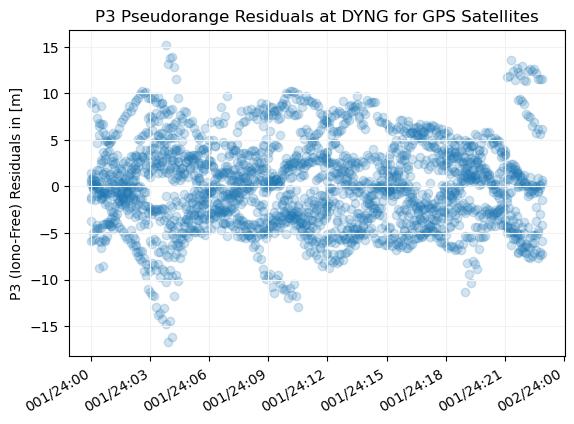

In [25]:
# Γραφική αναπαράσταση - Υπόλοιπα
fig, ax = plt.subplots()
ax.scatter(ephs, dl, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P3 (Iono-Free) Residuals in [m]")
plt.title("P3 Pseudorange Residuals at {:} for GPS Satellites".format(rnx.marker_name))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

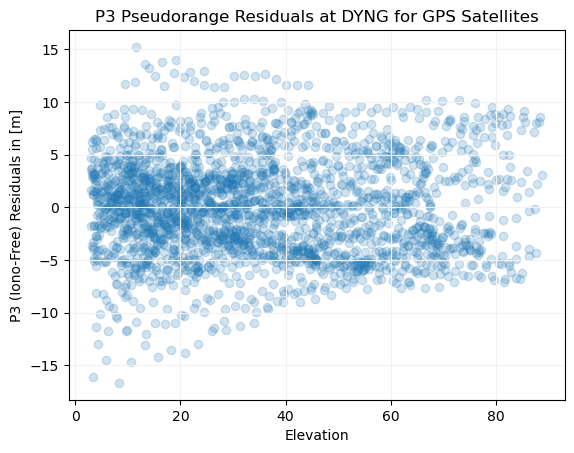

In [26]:
# Γραφική αναπαράσταση - Υπόλοιπα
fig, ax = plt.subplots()
ax.scatter(elvs, dl, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P3 (Iono-Free) Residuals in [m]")
plt.title("P3 Pseudorange Residuals at {:} for GPS Satellites".format(rnx.marker_name))
plt.xlabel("Elevation")
plt.show()

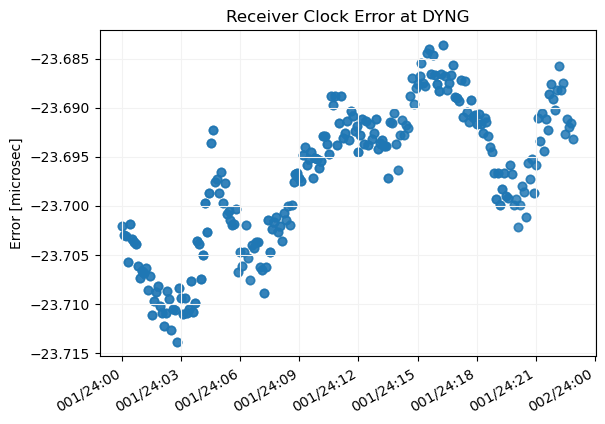

In [27]:
rec_clock_error = [0] * m
for i, obs in enumerate(raw_obs): rec_clock_error[i] = (x0[3+obs['nepoch']] / gs.C) * 1e6
fig, ax = plt.subplots()
ax.scatter(ephs, rec_clock_error, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("Error [microsec]")
plt.title("Receiver Clock Error at {:}".format(rnx.marker_name))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()